In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from torchvision import models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Загружаем датасет

In [451]:
batch_size = 100
shuffle_dataset = True

train_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
train_dl = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=shuffle_dataset)

test_dl = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [452]:
num_classes = 10 #количество классов заранее известно
input_size = 1*28 * 28 #размерность изображений
hidden_size = 512 #количество нейронов на скрытом слое
num_epochs = 10 #количество эпох
learning_rate = 0.001 #скорость обучения

In [453]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes),
    nn.Softmax(dim=1)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   

In [454]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 407050


In [60]:
def train(model, device, train_dl, optimizer, criterion, squeeze_inputs = False):
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for (inputs, targets) in train_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        if squeeze_inputs:
            inputs = inputs.reshape(-1, 28*28).to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
        total_samples += targets.shape[0]
        
        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices==targets)
    
    train_accuracy = float(correct_samples) / total_samples
    
    return total_loss, train_accuracy

In [61]:
def test(model, device, test_dl, squeeze_inputs = False):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            if squeeze_inputs:
                inputs = inputs.reshape(-1, 28*28).to(device)
            
            outputs = model(inputs)
            
            total_samples += targets.shape[0]
            _, predictions_indices = torch.max(outputs, 1)
            correct_samples += torch.sum(predictions_indices==targets)
            
    test_accuracy = correct_samples / total_samples
            
    return test_accuracy 

In [457]:
losses = []
for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer, criterion, squeeze_inputs=True)
    losses.append(total_loss.item())
    test_accuracy = test(model, device, test_dl, squeeze_inputs=True)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Loss: [1015.6366], Train_acc: [0.7811], Test_acc: [0.8161]
epoch [2]: Loss: [974.3380], Train_acc: [0.8408], Test_acc: [0.8385]
epoch [3]: Loss: [966.3576], Train_acc: [0.8522], Test_acc: [0.8460]
epoch [4]: Loss: [961.3726], Train_acc: [0.8604], Test_acc: [0.8508]
epoch [5]: Loss: [957.1381], Train_acc: [0.8672], Test_acc: [0.8595]
epoch [6]: Loss: [955.0070], Train_acc: [0.8704], Test_acc: [0.8613]
epoch [7]: Loss: [951.9008], Train_acc: [0.8753], Test_acc: [0.8544]
epoch [8]: Loss: [951.2330], Train_acc: [0.8763], Test_acc: [0.8626]
epoch [9]: Loss: [948.0023], Train_acc: [0.8820], Test_acc: [0.8671]
epoch [10]: Loss: [946.3320], Train_acc: [0.8845], Test_acc: [0.8630]


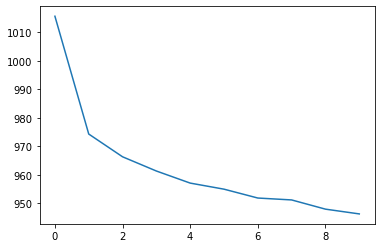

In [458]:
plt.plot(losses);

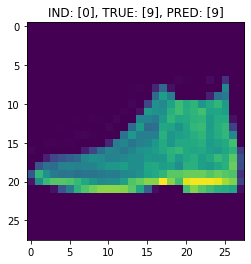

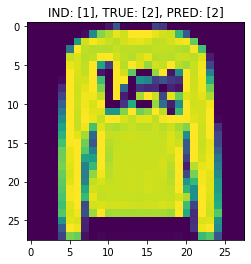

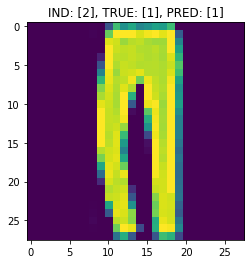

In [459]:
model.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        
        inputs = inputs.reshape(-1, 28*28).to(device)

        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred) in enumerate(zip(inputs, targets, predictions_indices)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            plt.imshow(inpt.view(28, 28))
            plt.show()
            if i==2:
                break
        break

In [460]:
model.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        
        inputs = inputs.reshape(-1, 28*28).to(device)

        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))
        

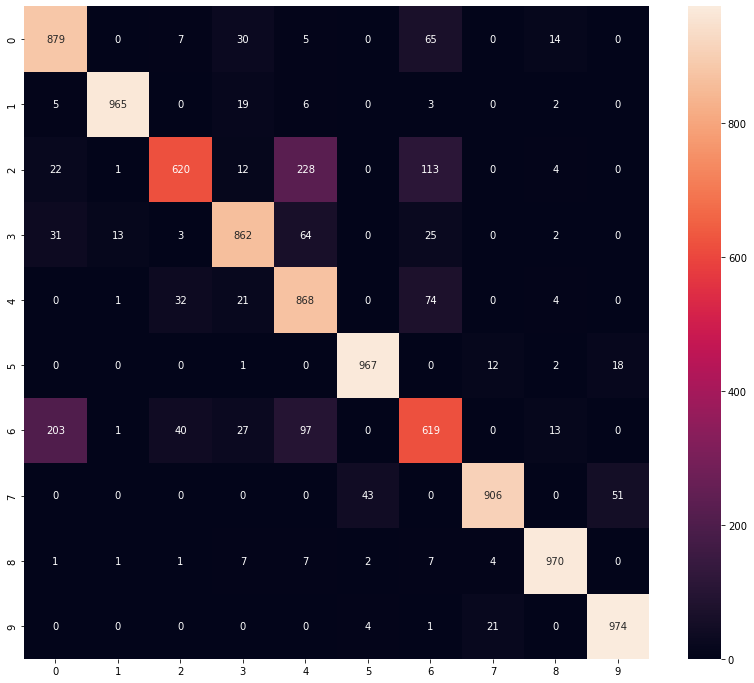

In [461]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [462]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.8630


In [463]:
torch.save(model.state_dict(), 'model_1_1_fashion_mnist.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [473]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=10),
#             nn.LogSoftmax(dim=1),
        )
        
        
    def forward(self, x):
        x = self.conv1(x) # первый сверточный слой
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x

In [490]:
learning_rate = 0.01
num_epochs = 10

In [491]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

In [492]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 1475338


In [493]:
losses = []
for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer, criterion, squeeze_inputs=False)
    losses.append(total_loss.item())
    test_accuracy = test(model, device, test_dl, squeeze_inputs=False)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >= 0.9:
        break

epoch [1]: Loss: [1253.4064], Train_acc: [0.8051], Test_acc: [0.8652]
epoch [2]: Loss: [198.9782], Train_acc: [0.8797], Test_acc: [0.8822]
epoch [3]: Loss: [174.5037], Train_acc: [0.8948], Test_acc: [0.8629]
epoch [4]: Loss: [163.3981], Train_acc: [0.9005], Test_acc: [0.8627]
epoch [5]: Loss: [158.8585], Train_acc: [0.9038], Test_acc: [0.8941]
epoch [6]: Loss: [155.1055], Train_acc: [0.9078], Test_acc: [0.8978]
epoch [7]: Loss: [157.5635], Train_acc: [0.9063], Test_acc: [0.8722]
epoch [8]: Loss: [157.8130], Train_acc: [0.9066], Test_acc: [0.8843]
epoch [9]: Loss: [161.1746], Train_acc: [0.9059], Test_acc: [0.8990]
epoch [10]: Loss: [164.4669], Train_acc: [0.9045], Test_acc: [0.8888]


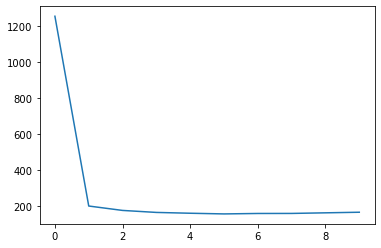

In [494]:
plt.plot(losses);

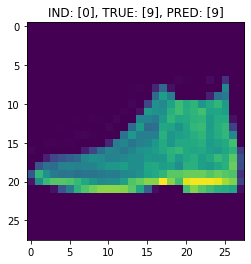

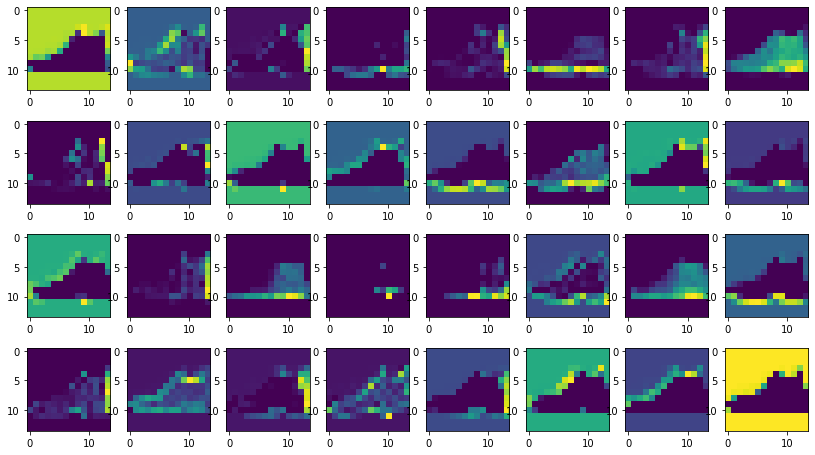

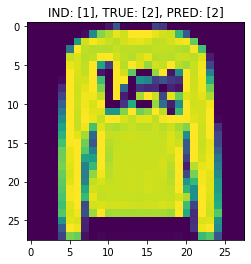

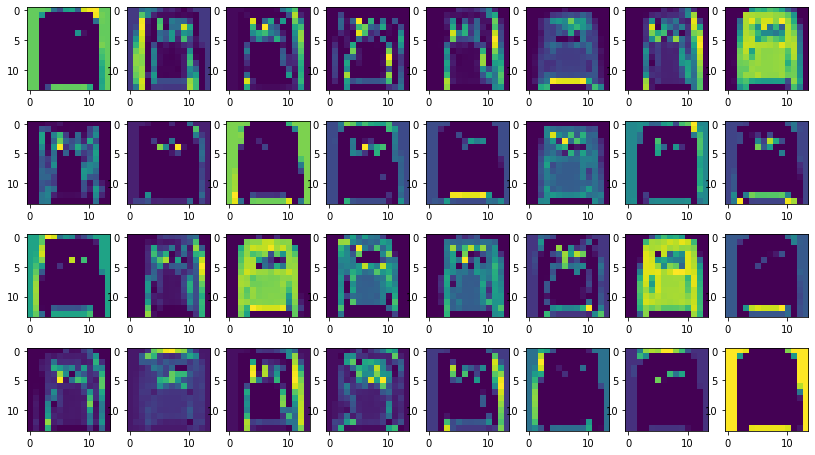

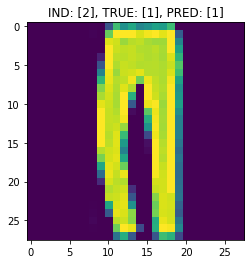

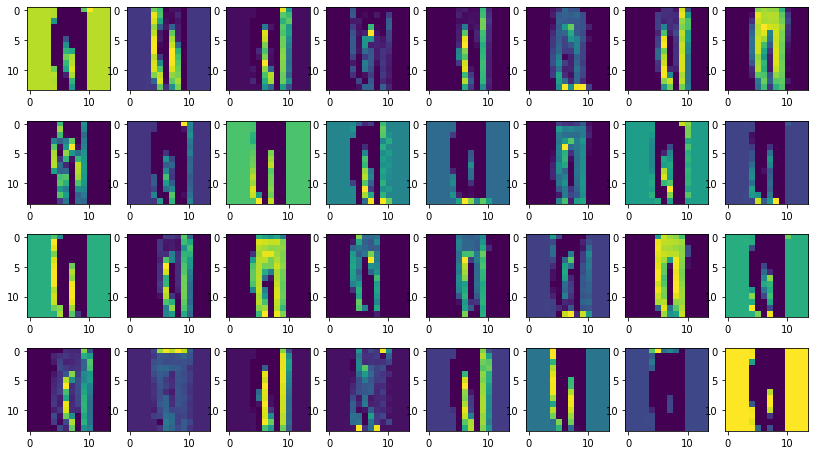

In [495]:
model.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = model.forward(inputs)
        outputs_1l = model.forward_1l(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            plt.imshow(inpt.view(28, 28))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
                    axj.imshow(out_1l[j])
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [496]:
model.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        
        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))
        

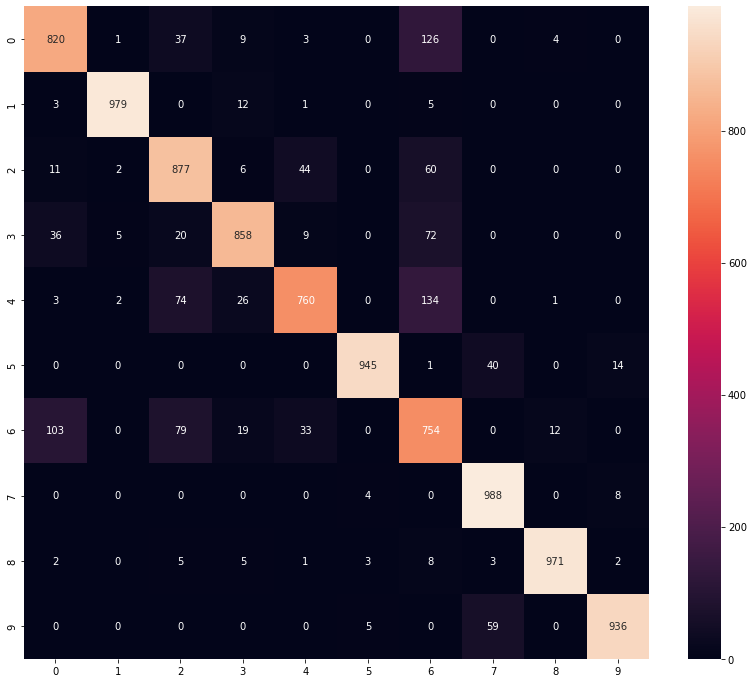

In [497]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [498]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.8888


##  2. Классификация изображений (датасет CIFAR 10) 

In [499]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [539]:
im_size = 32 * 32 * 3

class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(im_size, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(4, -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


In [540]:
cifar_net = CIFARNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net.parameters(), lr=0.01, momentum=0.9)


In [541]:
param_num = sum(p.numel() for p in cifar_net.parameters())
print("Количество параметров:", param_num)

Количество параметров: 394634


In [542]:
losses = []
for epoch in range(3):
    total_loss, train_accuracy = train(cifar_net, device, trainloader, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(cifar_net, device, testloader)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Loss: [20763.8320], Train_acc: [0.4129], Test_acc: [0.4676]
epoch [2]: Loss: [18754.1562], Train_acc: [0.4758], Test_acc: [0.4748]
epoch [3]: Loss: [17811.4141], Train_acc: [0.5035], Test_acc: [0.4747]


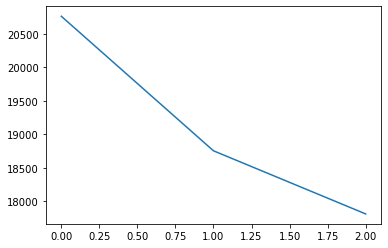

In [543]:
plt.plot(losses);

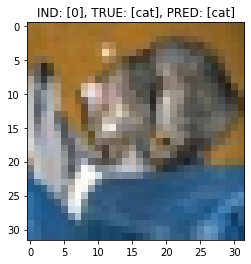

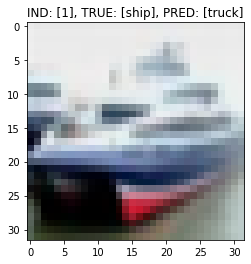

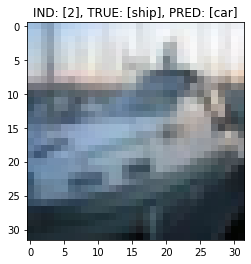

In [552]:
cifar_net.eval()

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cifar_net(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred) in enumerate(zip(inputs, targets, predictions_indices)):
            plt.title(f"IND: [{i}], TRUE: [{classes[trgt]}], PRED: [{classes[pred]}]")
            inpt = (inpt / 2 + 0.5).numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            plt.show()
            if i==2:
                break
        break

In [553]:
cifar_net.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cifar_net(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))
        

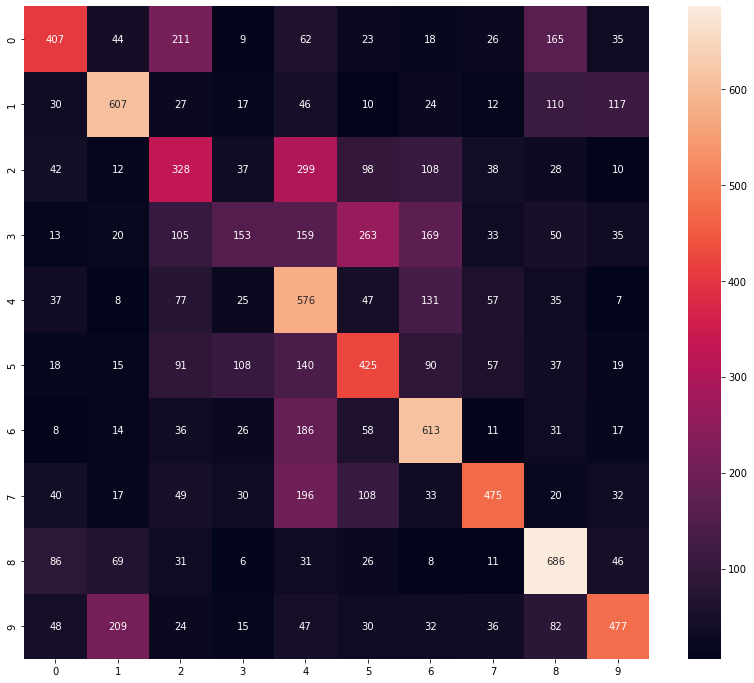

In [554]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [555]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.4747


In [556]:
torch.save(cifar_net.state_dict(), 'model_2_1_cifar10.pth')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [579]:
class CIFARNet2(nn.Module):
    def __init__(self):
        super(CIFARNet2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=600),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=10),
#             nn.LogSoftmax(dim=1),
        )
        
        
    def forward(self, x):
        x = self.conv1(x) # первый сверточный слой
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x


In [580]:
cifar_net2 = CIFARNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net2.parameters(), lr=0.001, momentum=0.9)

In [581]:
param_num = sum(p.numel() for p in cifar_net2.parameters())
print("Количество параметров:", param_num)

Количество параметров: 1975114


In [582]:
losses = []
for epoch in range(10):
    total_loss, train_accuracy = train(cifar_net2, device, trainloader, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(cifar_net2, device, testloader)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.7:
        break

epoch [1]: Loss: [17291.4395], Train_acc: [0.5111], Test_acc: [0.6189]
epoch [2]: Loss: [13059.1357], Train_acc: [0.6374], Test_acc: [0.6692]
epoch [3]: Loss: [11498.0889], Train_acc: [0.6832], Test_acc: [0.6876]
epoch [4]: Loss: [10589.2119], Train_acc: [0.7085], Test_acc: [0.6957]
epoch [5]: Loss: [9892.5820], Train_acc: [0.7269], Test_acc: [0.7049]
epoch [6]: Loss: [9387.4033], Train_acc: [0.7398], Test_acc: [0.7086]
epoch [7]: Loss: [8956.5029], Train_acc: [0.7519], Test_acc: [0.7193]
epoch [8]: Loss: [8580.6699], Train_acc: [0.7645], Test_acc: [0.6873]
epoch [9]: Loss: [8289.0000], Train_acc: [0.7705], Test_acc: [0.7207]
epoch [10]: Loss: [7991.6875], Train_acc: [0.7778], Test_acc: [0.7178]


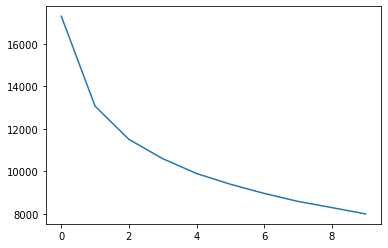

In [583]:
plt.plot(losses);

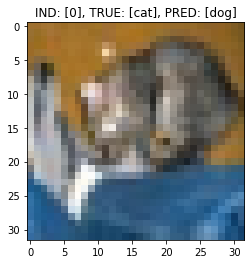

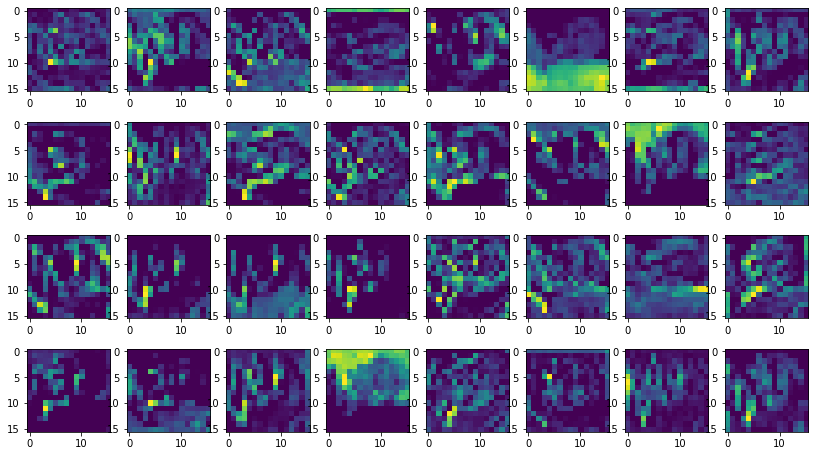

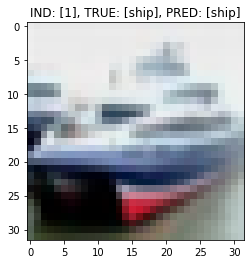

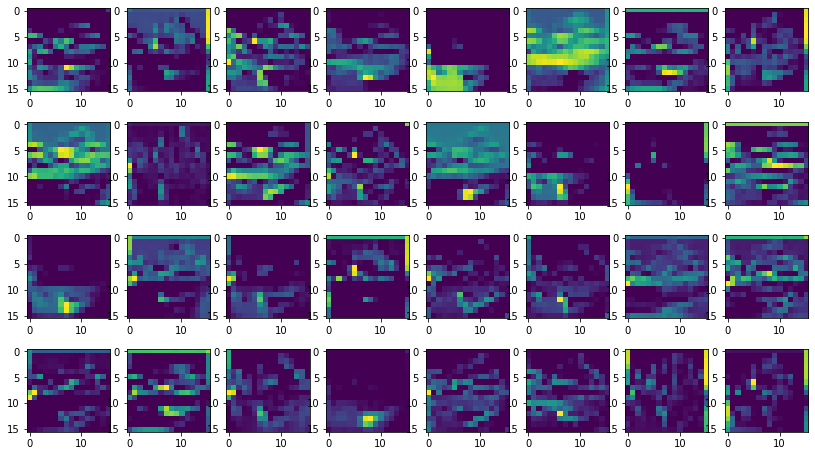

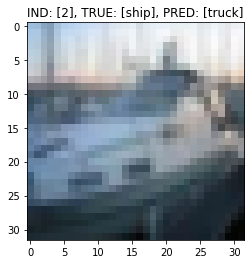

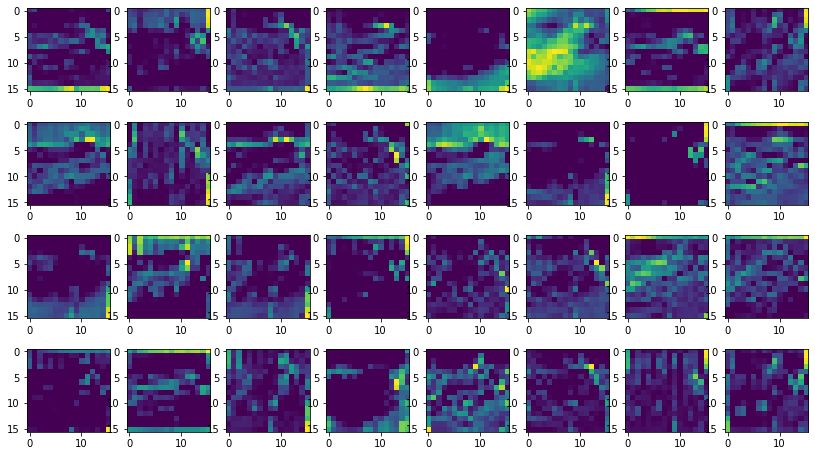

In [590]:
cifar_net2.eval()

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cifar_net2.forward(inputs)
        outputs_1l = cifar_net2.forward_1l(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{classes[trgt]}], PRED: [{classes[pred]}]")
            inpt = (inpt / 2 + 0.5).numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
                    curr = (out_1l[j] / 2 +0.5).numpy()
#                     print(curr.shape)
                    axj.imshow(curr)
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [591]:
cifar_net2.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cifar_net2(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

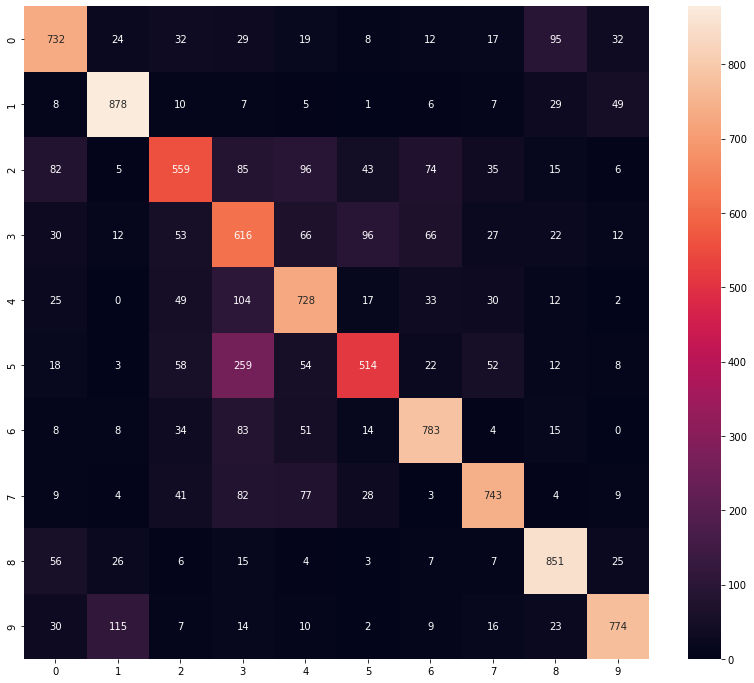

In [592]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [593]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.7178


In [594]:
torch.save(cifar_net2.state_dict(), 'model_2_2_cifar10.pth')

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [801]:
train_dl = torch.utils.data.DataLoader(
    datasets.ImageFolder('./data/training/training',
        transform=transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])),
    batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(
    datasets.ImageFolder('./data/validation/validation',
        transform=transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])),
    batch_size=32, shuffle=False)

In [809]:
class MonkeyNet(nn.Module):
    def __init__(self):
        super(MonkeyNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=5,
                padding=1,
            ),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                padding=1,
            ),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                padding=1,
            ),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=10*10*128, out_features=1200),
#             nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=1200, out_features=10),
#             nn.Softmax(dim=1),
        )
        
        
    def forward(self, x):
        x = self.conv1(x) # первый сверточный слой
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x

In [810]:
monkey_net = MonkeyNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(monkey_net.parameters(), lr=0.0001)

In [811]:
param_num = sum(p.numel() for p in monkey_net.parameters())
print("Количество параметров:", param_num)

Количество параметров: 15631834


In [812]:
losses = []
for epoch in range(10):
    total_loss, train_accuracy = train(monkey_net, device, train_dl, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(monkey_net, device, test_dl)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.6:
        break

epoch [1]: Loss: [71.0947], Train_acc: [0.2808], Test_acc: [0.3529]
epoch [2]: Loss: [50.0187], Train_acc: [0.5269], Test_acc: [0.5110]
epoch [3]: Loss: [39.3949], Train_acc: [0.6363], Test_acc: [0.5478]
epoch [4]: Loss: [35.8175], Train_acc: [0.6572], Test_acc: [0.6029]


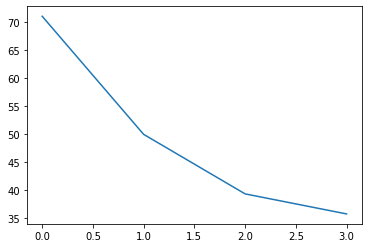

In [813]:
plt.plot(losses);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


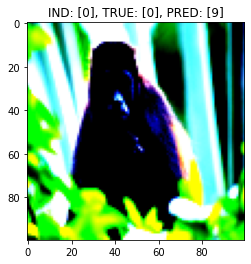

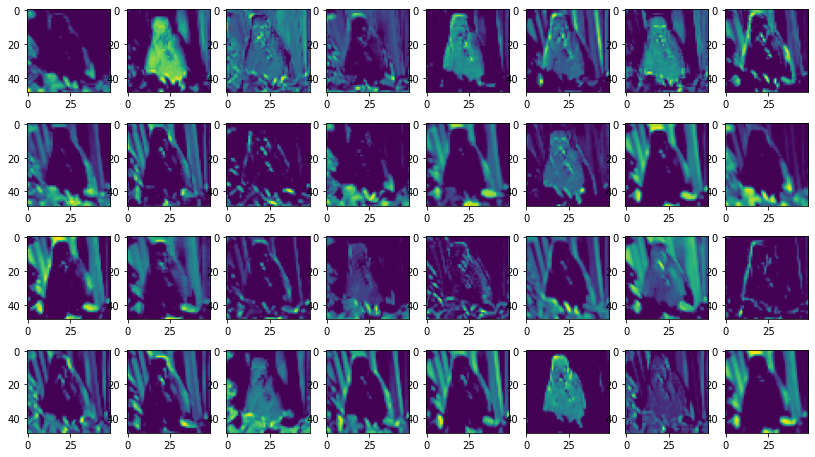

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


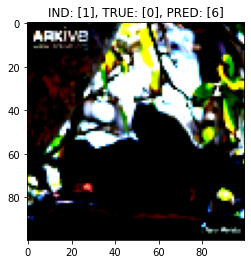

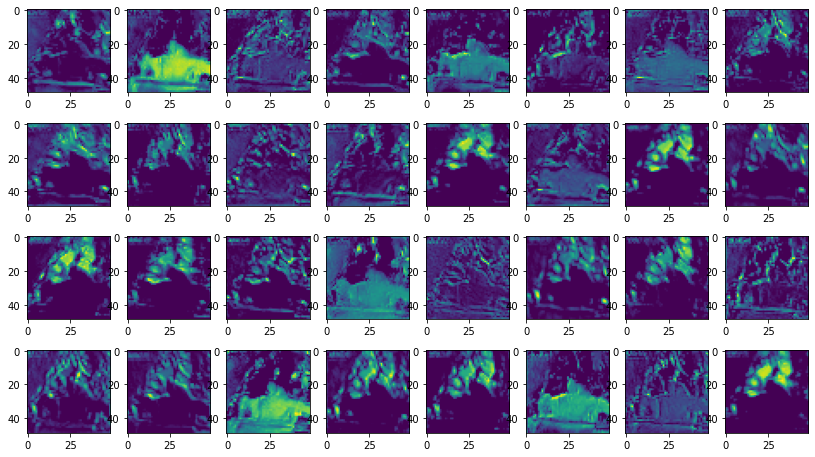

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


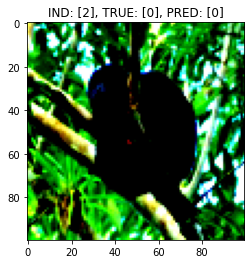

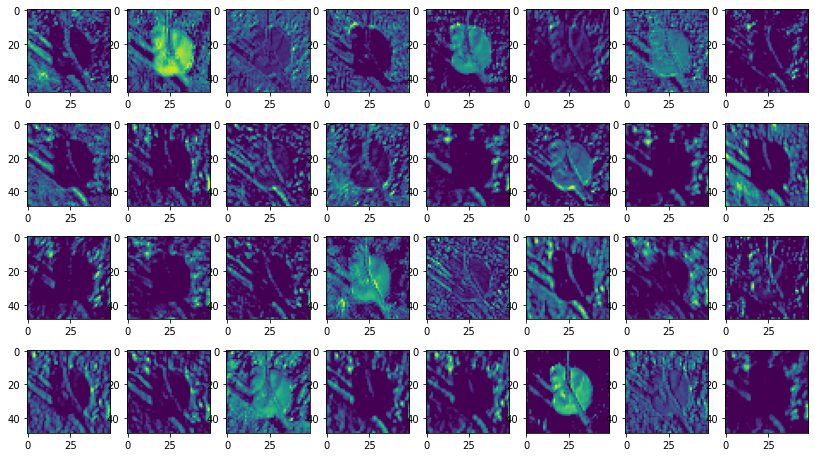

In [814]:
monkey_net.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = monkey_net.forward(inputs)
        outputs_1l = monkey_net.forward_1l(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            inpt = inpt.numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
#                     curr = (out_1l[j]).numpy()
#                     print(curr.shape)
                    axj.imshow(out_1l[j])
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [815]:
monkey_net.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = monkey_net(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

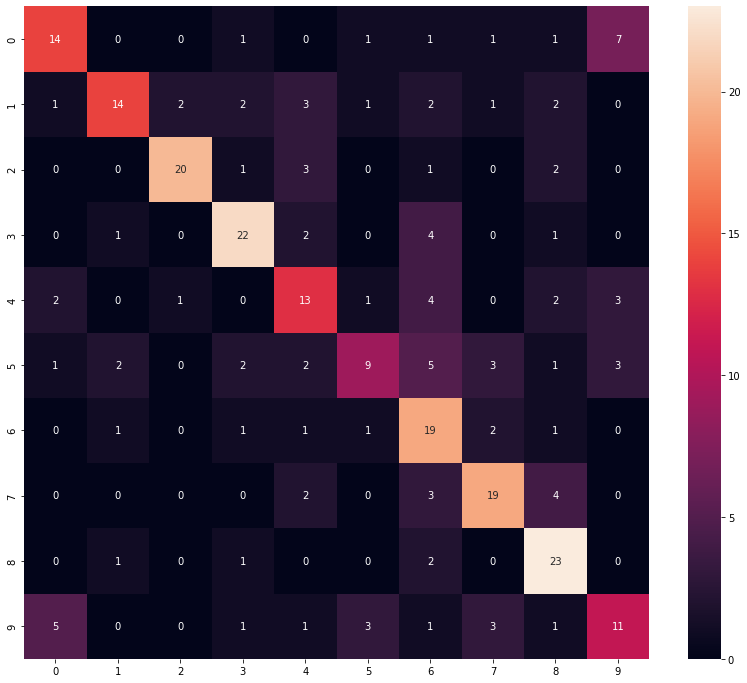

In [816]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [817]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.6029


In [818]:
torch.save(monkey_net.state_dict(), 'model_3_1_monkey.pth')

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [927]:
dataset =  datasets.ImageFolder(
    './data/cats_dogs/train',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
)
trainx, testx = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dl = torch.utils.data.DataLoader(
    dataset=trainx,
    batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(
    dataset=testx,
    batch_size=32, shuffle=False)

In [938]:
class CatsDogsNet(nn.Module):
    def __init__(self):
        super(CatsDogsNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=7,
                padding=3,
                stride=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2
            ),
        )
        self.average_pool = nn.Sequential(
            nn.AvgPool2d(
                kernel_size=2
            )
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=2),
#             nn.Dropout(p=0.25),
#             nn.Linear(in_features=600, out_features=120),
#             nn.Linear(in_features=120, out_features=2),
#             nn.Softmax(dim=1),
        )
        
        
    def forward(self, x):
        x = self.conv1(x) # первый сверточный слой
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.average_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x

In [939]:
cats_dogs_net = CatsDogsNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cats_dogs_net.parameters(), lr=0.005)

In [940]:
param_num = sum(p.numel() for p in cats_dogs_net.parameters())
print("Количество параметров:", param_num)

Количество параметров: 4734978


In [941]:
losses = []
for epoch in range(10):
    total_loss, train_accuracy = train(cats_dogs_net, device, train_dl, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(cats_dogs_net, device, test_dl)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.8:
        break

epoch [1]: Loss: [443.5990], Train_acc: [0.5464], Test_acc: [0.5920]
epoch [2]: Loss: [409.7157], Train_acc: [0.6109], Test_acc: [0.6748]
epoch [3]: Loss: [353.1260], Train_acc: [0.7055], Test_acc: [0.7112]
epoch [4]: Loss: [305.2039], Train_acc: [0.7626], Test_acc: [0.7906]
epoch [5]: Loss: [263.4402], Train_acc: [0.8072], Test_acc: [0.8242]


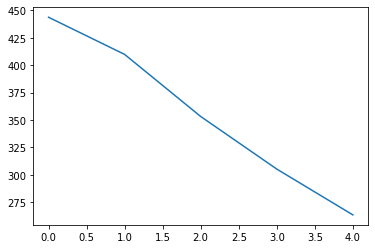

In [942]:
plt.plot(losses);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


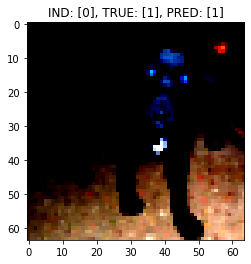

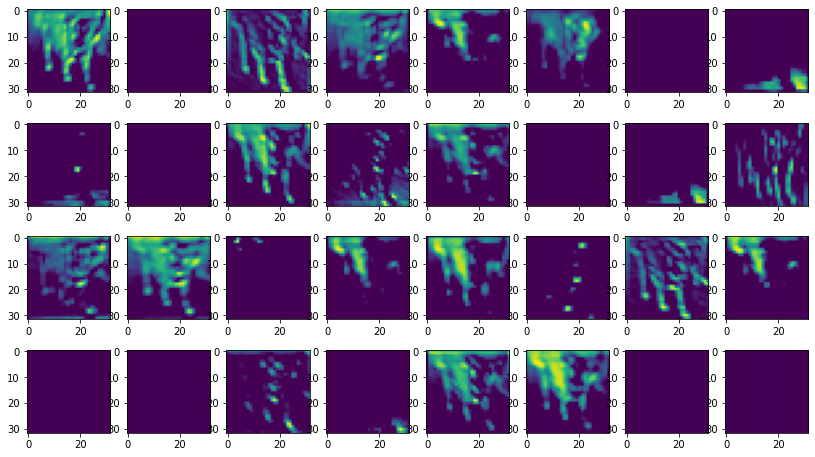

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


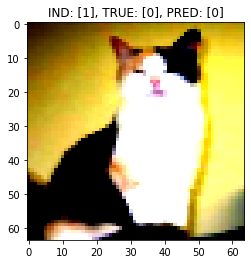

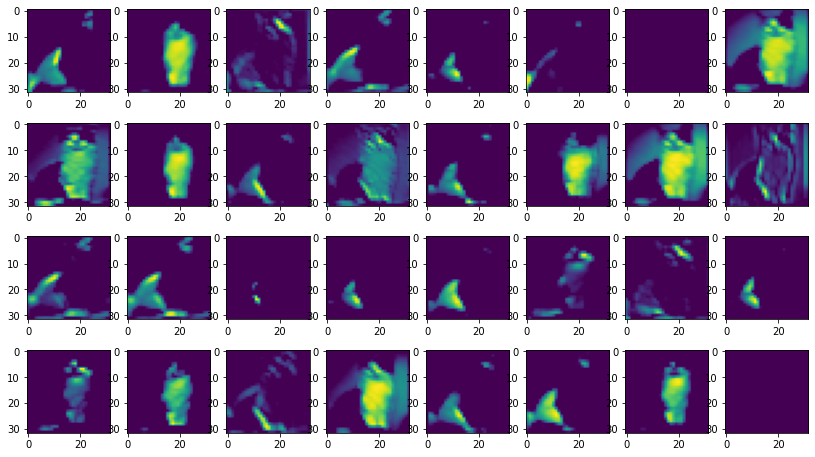

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


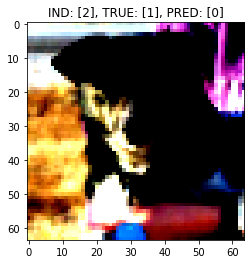

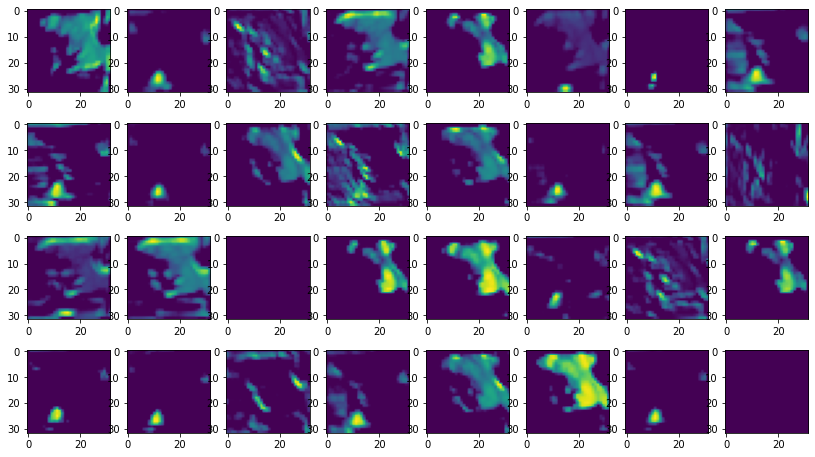

In [943]:
cats_dogs_net.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cats_dogs_net.forward(inputs)
        outputs_1l = cats_dogs_net.forward_1l(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            inpt = inpt.numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
#                     curr = (out_1l[j]).numpy()
#                     print(curr.shape)
                    axj.imshow(out_1l[j])
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [944]:
cats_dogs_net.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = cats_dogs_net(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

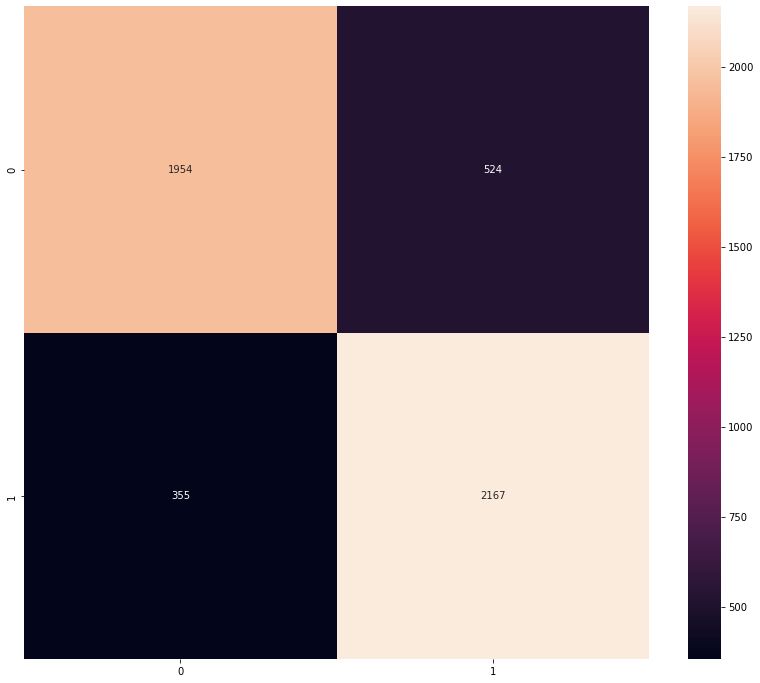

In [945]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [946]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.8242


In [947]:
torch.save(cats_dogs_net.state_dict(), 'model_3_2_cats_dogs.pth')

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [87]:
transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ])

train_dl = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        './data/training/training',
        transform = transform,
    ),
    batch_size=32,
    shuffle=True
)
test_dl = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        './data/validation/validation',
        transform=transform,
    ),
    batch_size=32,
    shuffle=False
)

In [88]:
#сст чк
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16.classifier[6] = nn.Linear(4096, 10)

In [89]:
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.005)

In [90]:
param_num = sum(p.numel() for p in vgg16.parameters())
print("Количество параметров:", param_num)

Количество параметров: 134301514


In [91]:
losses = []
for epoch in range(5):
    total_loss, train_accuracy = train(vgg16, device, train_dl, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(vgg16, device, test_dl)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.95:
        break

epoch [1]: Loss: [15428.3975], Train_acc: [0.0820], Test_acc: [0.1213]
epoch [2]: Loss: [133.2592], Train_acc: [0.0948], Test_acc: [0.0993]
epoch [3]: Loss: [622.4456], Train_acc: [0.1030], Test_acc: [0.0956]
epoch [4]: Loss: [1783.0907], Train_acc: [0.0966], Test_acc: [0.1029]
epoch [5]: Loss: [2653.0347], Train_acc: [0.1094], Test_acc: [0.0956]


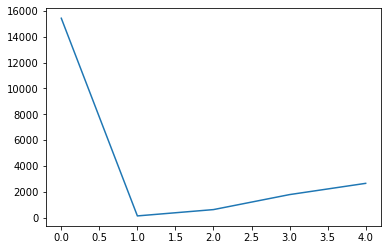

In [92]:
plt.plot(losses);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


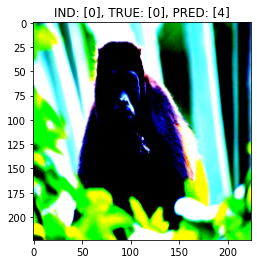

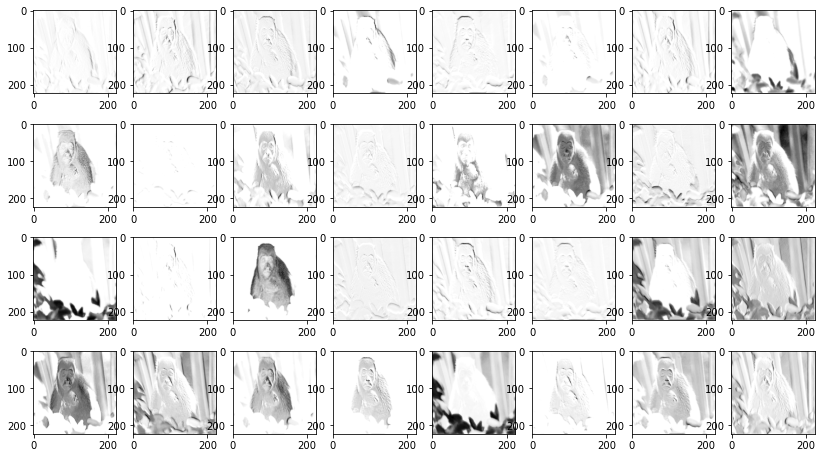

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


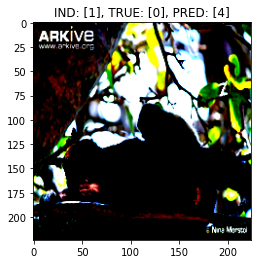

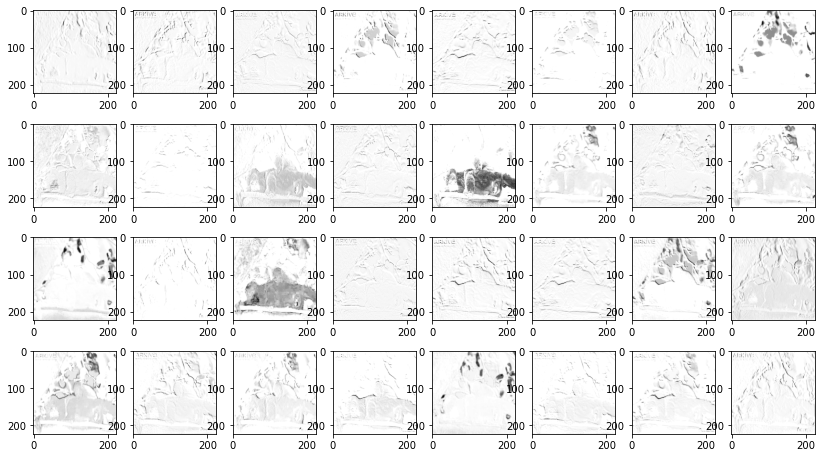

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


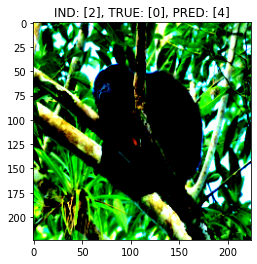

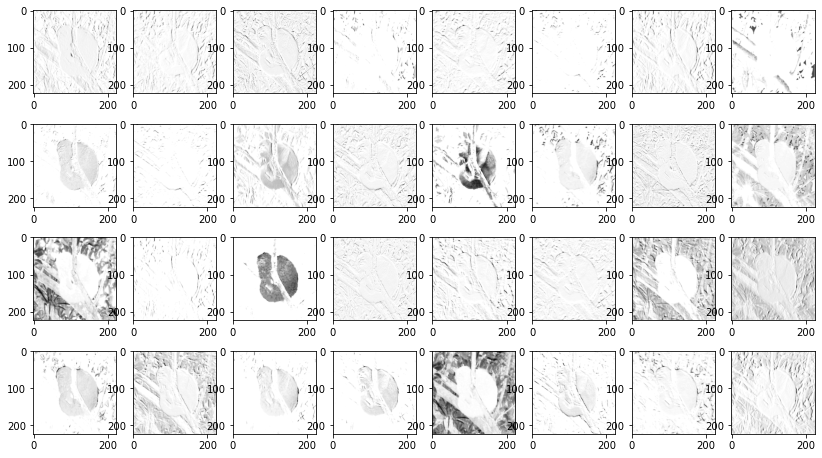

In [106]:
vgg16.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = vgg16.forward(inputs)
        outputs_1l = model.features[:2](inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            inpt = inpt.numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
#                     curr = (out_1l[j]).numpy()
#                     print(curr.shape)
                    axj.imshow(out_1l[j], cmap='Greys')
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [107]:
vgg16.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = vgg16(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

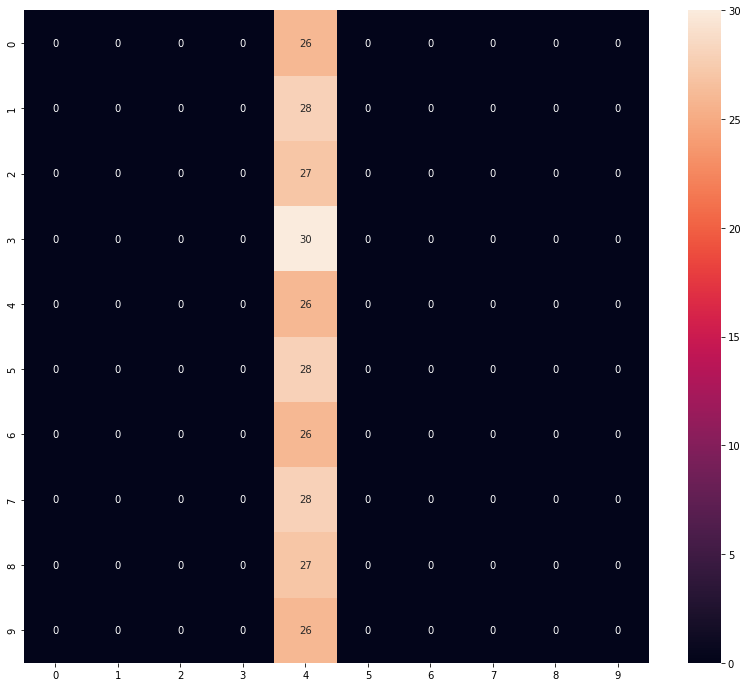

In [108]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [109]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.0956


In [110]:
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.005)
param_num = sum(p.numel() for p in vgg16.parameters())
print("Количество параметров:", param_num)

Количество параметров: 134301514


In [111]:
losses = []
for epoch in range(5):
    total_loss, train_accuracy = train(vgg16, device, train_dl, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(vgg16, device, test_dl)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.99:
        break

epoch [1]: Loss: [997.9837], Train_acc: [0.4676], Test_acc: [0.8382]
epoch [2]: Loss: [332.6454], Train_acc: [0.8551], Test_acc: [0.7610]
epoch [3]: Loss: [708.2809], Train_acc: [0.8851], Test_acc: [0.9228]
epoch [4]: Loss: [770.3640], Train_acc: [0.9107], Test_acc: [0.9485]
epoch [5]: Loss: [1192.5104], Train_acc: [0.9234], Test_acc: [0.8199]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


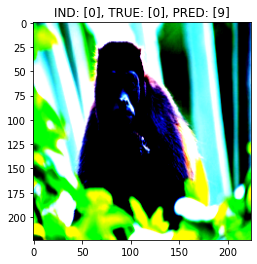

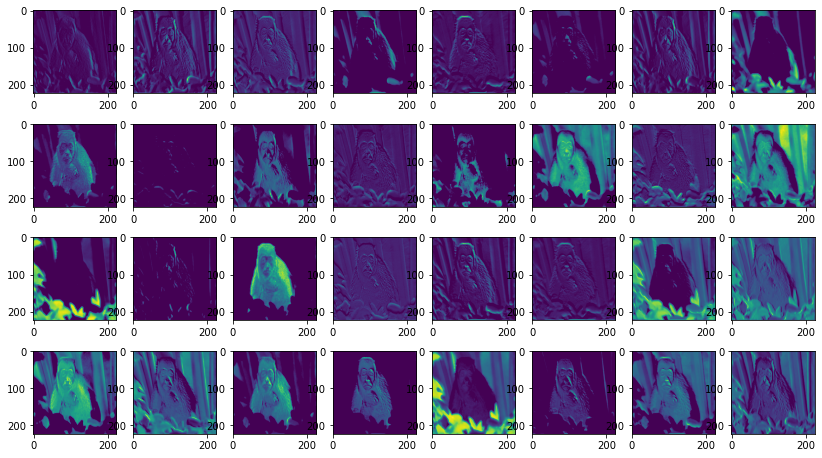

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


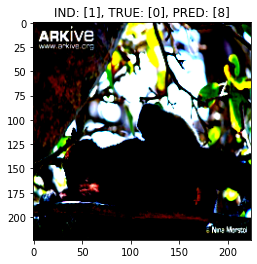

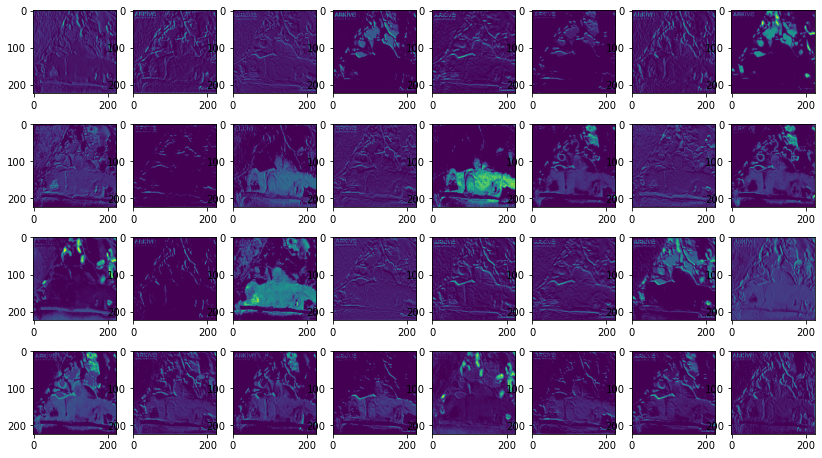

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


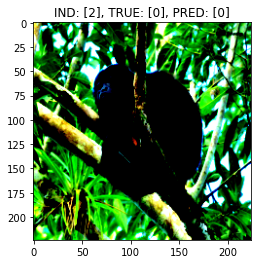

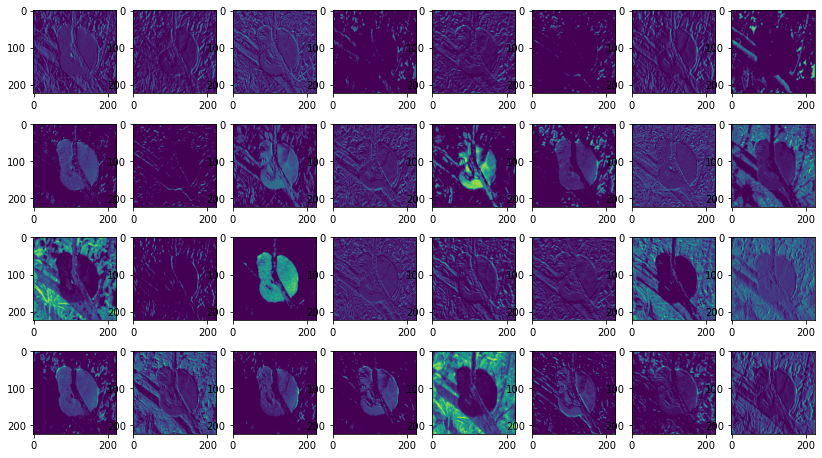

In [116]:
vgg16.eval()

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = vgg16.forward(inputs)
        outputs_1l = vgg16.features[:2](inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            inpt = inpt.numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
#                     curr = (out_1l[j]).numpy()
#                     print(curr.shape)
                    axj.imshow(out_1l[j])
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [113]:
vgg16.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = vgg16(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

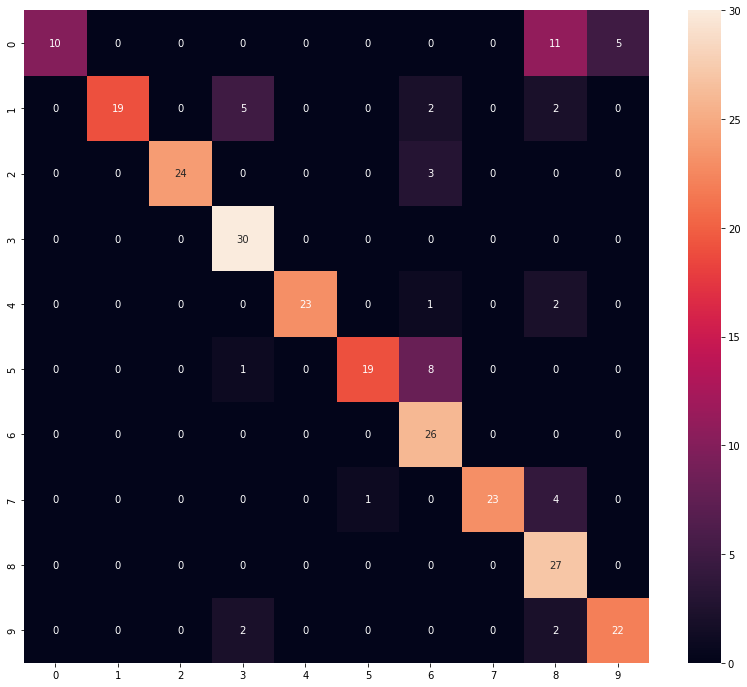

In [114]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [115]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.8199


In [118]:
torch.save(vgg16.state_dict(), 'model_4_1_vgg16.pth')

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [119]:
dataset =  datasets.ImageFolder(
    './data/cats_dogs/train',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
)
trainx, testx = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dl = torch.utils.data.DataLoader(
    dataset=trainx,
    batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(
    dataset=testx,
    batch_size=32, shuffle=False)

In [149]:
#сст чк
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(512, 10)

for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True
    
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.005)
param_num = sum(p.numel() for p in resnet18.parameters())
print("Количество параметров:", param_num)

Количество параметров: 11181642


In [155]:
losses = []
for epoch in range(5):
    total_loss, train_accuracy = train(resnet18, device, train_dl, optimizer, criterion)
    losses.append(total_loss.item())
    test_accuracy = test(resnet18, device, test_dl)
    
    print(f"epoch [{epoch+1}]: Loss: [{total_loss:.4f}], Train_acc: [{train_accuracy:.4f}],"
         f" Test_acc: [{test_accuracy:.4f}]")
    if test_accuracy >=0.97:
        break

epoch [1]: Loss: [72.0571], Train_acc: [0.9619], Test_acc: [0.9742]
epoch [2]: Loss: [79.6430], Train_acc: [0.9612], Test_acc: [0.9744]
epoch [3]: Loss: [71.1196], Train_acc: [0.9656], Test_acc: [0.9786]
epoch [4]: Loss: [71.9457], Train_acc: [0.9651], Test_acc: [0.9658]
epoch [5]: Loss: [69.3132], Train_acc: [0.9674], Test_acc: [0.9790]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


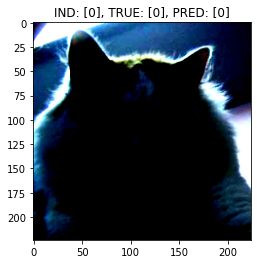

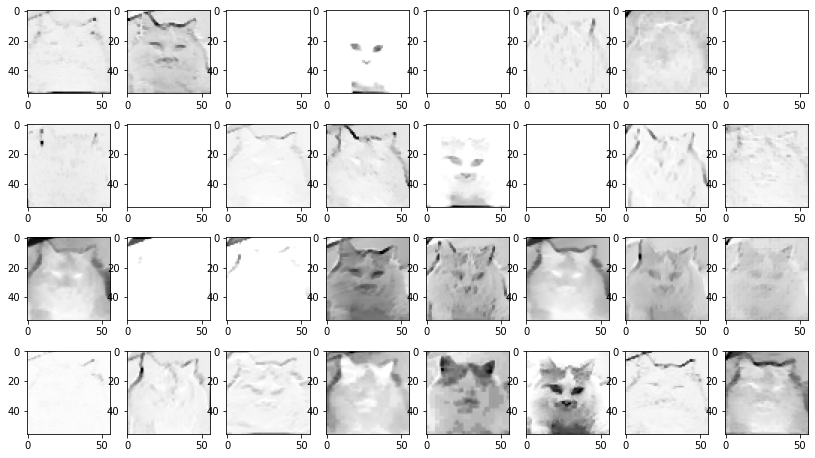

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


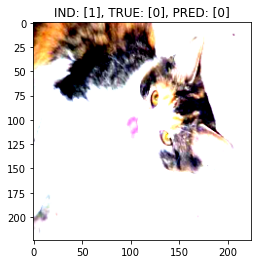

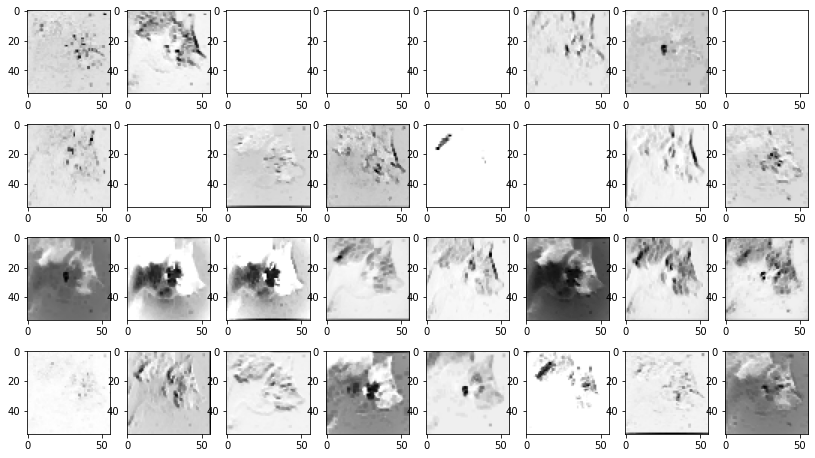

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


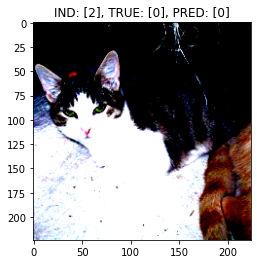

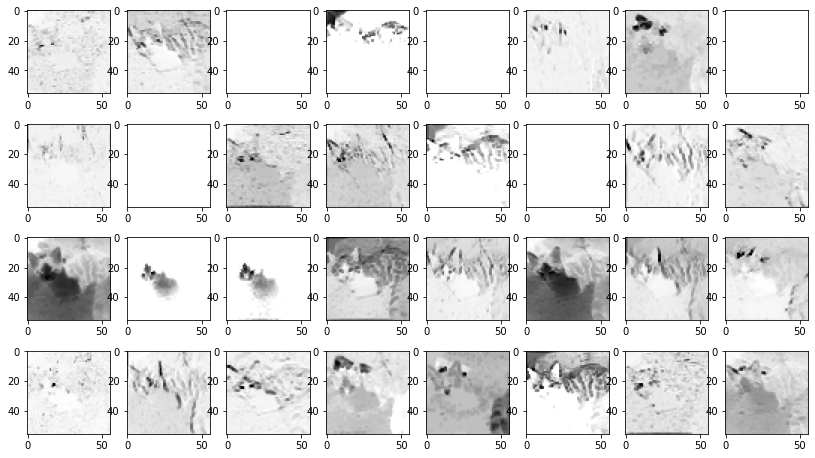

In [156]:
resnet18.eval()

with torch.no_grad():
    first_layer = nn.Sequential(*list(resnet18.children())[:4])
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = resnet18.forward(inputs)
        outputs_1l = first_layer(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        
        for i, (inpt, trgt, pred, out_1l) in enumerate(zip(inputs, targets, predictions_indices, outputs_1l)):
            plt.title(f"IND: [{i}], TRUE: [{trgt}], PRED: [{pred}]")
            inpt = inpt.numpy()
            plt.imshow(np.transpose(inpt, (1, 2, 0)))
            fig, ax = plt.subplots(4,8, figsize=(14, 8))
        
            j = 0
            for axi in ax:
                for axj in axi:
                    axj.imshow(out_1l[j], cmap="Greys")
                    j+=1
                    
            plt.show()
            if i==2:
                break
        break

In [157]:
resnet18.eval()

true = torch.empty(0)
predict = torch.empty(0)

with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)        

        outputs = resnet18(inputs)

        _, predictions_indices = torch.max(outputs, 1)
        
        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

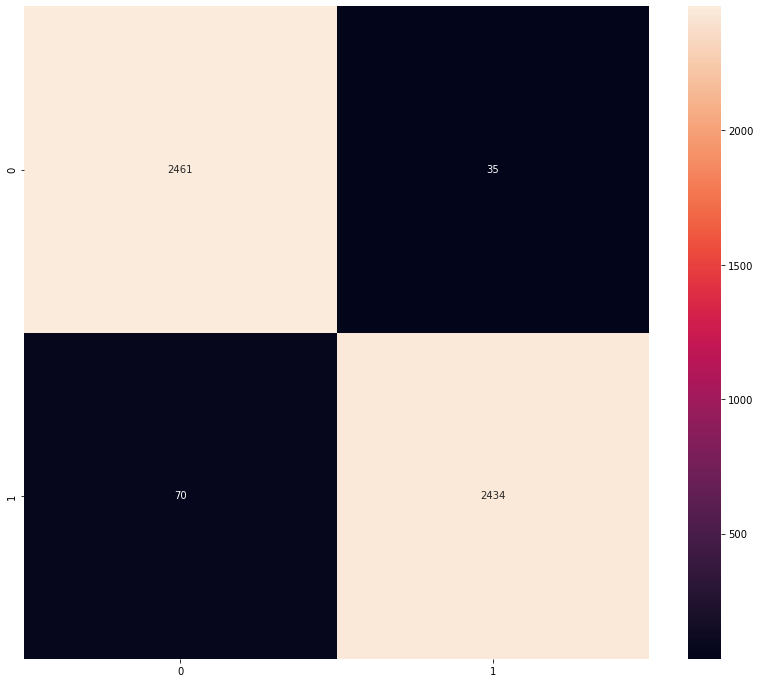

In [158]:
plt.figure(figsize=(14,12))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.numpy().astype("int"), predict.numpy().astype("int")),
    ),
    annot=True,
    fmt="d"
);

In [159]:
total_accuracy = torch.sum(true==predict) / true.shape[0]
print(f"Accuracy: {total_accuracy:.4f}")

Accuracy: 0.9790


In [160]:
torch.save(resnet18.state_dict(), 'model_4_2_resnet18.pth')